# CaBi ML fitting champion

5/26: This is the best performing model so far.
* At this point, I've found that dc_pop is more predictive than the dock/station variables and cabi_active_members_day_key and daylight_hours is more predictive than cabi_active_members_monthly
* Now we can try tweaking other things


## 0. Data load, shaping, and split
* Read in data from AWS
  * Check for high pairwise correlation
* Encode time variable (day_of_year) as cyclical
* Split into Xtrain, Xtest, ytrain, ytest based on date
  * Specify feature and target columns

In [1]:
# Read in data from AWS

from util_functions import *
import numpy as np
import pandas as pd
import time
start_time = time.perf_counter()

set_env_path()
conn, cur = aws_connect()

# fullquery contains all of the variables within consideration

fullquery = """
SELECT 
EXTRACT(DOY FROM date) as day_of_year,
date,
daylight_hours,
apparenttemperaturehigh,
apparenttemperaturelow,
cloudcover,
dewpoint,
humidity,
precipaccumulation,
precipintensitymax,
precipprobability,
rain,
snow,
visibility,
windspeed,
us_holiday,
nats_single,
nats_double,
dc_bike_event,
dc_pop,
cabi_bikes_avail,
cabi_stations_alx,
cabi_stations_arl,
cabi_stations_ffx,
cabi_stations_mcn,
cabi_stations_mcs,
cabi_stations_wdc,
cabi_docks_alx,
cabi_docks_arl,
cabi_docks_ffx,
cabi_docks_mcn,
cabi_docks_mcs,
cabi_docks_wdc,
cabi_stations_tot,
cabi_docks_tot,
cabi_dur_empty_wdc,
cabi_dur_full_wdc,
cabi_dur_empty_arl,
cabi_dur_full_arl,
cabi_dur_full_alx,
cabi_dur_empty_alx,
cabi_dur_empty_mcs,
cabi_dur_full_mcs,
cabi_dur_full_mcn,
cabi_dur_empty_mcn,
cabi_dur_full_ffx,
cabi_dur_empty_ffx,
cabi_dur_empty_tot,
cabi_dur_full_tot,
cabi_active_members_day_key,
cabi_active_members_monthly,
cabi_active_members_annual,
cabi_trips_wdc_to_wdc,
cabi_trips_wdc_to_wdc_casual
from final_db"""

query = """
SELECT 
EXTRACT(DOY FROM date) as day_of_year,
date,
daylight_hours,
apparenttemperaturehigh,
cloudcover,
humidity,
precipaccumulation,
precipintensitymax,
precipprobability,
rain,
snow,
visibility,
windspeed,
us_holiday,
nats_single,
nats_double,
dc_bike_event,
dc_pop,
cabi_dur_empty_arl,
cabi_dur_full_arl,
cabi_dur_full_alx,
cabi_dur_empty_alx,
cabi_dur_empty_mcs,
cabi_dur_full_mcs,
cabi_dur_full_mcn,
cabi_dur_empty_mcn,
cabi_trips_wdc_to_wdc,
cabi_trips_wdc_to_wdc_casual
from final_db"""

pd.options.display.max_rows = None
pd.options.display.max_columns = None

df = pd.read_sql(query, con=conn)

# Setting date to index for easier splitting
df.set_index(df.date, drop=True, inplace=True)
df.index = pd.to_datetime(df.index)

print("We have {} instances and {} features".format(*df.shape))

We have 2780 instances and 28 features


In [2]:
# Summary statistics

df.describe(percentiles=[.5]).round(3).transpose()

,count,mean,std,min,50%,max
day_of_year,2780.0,182.697,107.702,1.000,182.000,366.000
daylight_hours,2780.0,12.077,2.021,9.000,12.000,15.000
apparenttemperaturehigh,2780.0,64.306,20.594,2.240,65.890,113.670
cloudcover,2780.0,0.340,0.244,0.000,0.270,1.000
humidity,2780.0,0.669,0.137,0.210,0.670,0.970
precipaccumulation,2780.0,0.045,0.527,0.000,0.000,21.427
precipintensitymax,2780.0,0.029,0.072,0.000,0.001,1.185
precipprobability,2780.0,0.282,0.373,0.000,0.000,1.000
rain,2780.0,0.454,0.498,0.000,0.000,1.000
snow,2780.0,0.040,0.196,0.000,0.000,1.000


In [3]:
def print_highly_correlated(df, features, threshold=0.75):
    """ 
    Prints highly correlated feature pairs in df.
    """
    corr_df = df[features].corr()
    # Select pairs above threshold
    correlated_features = np.where(np.abs(corr_df) > threshold)
    # Avoid duplication
    correlated_features = [(corr_df.iloc[x,y], x, y) for x, y in zip(*correlated_features) if x != y and x < y]
    # Sort by abs(correlation)
    s_corr_list = sorted(correlated_features, key=lambda x: -abs(x[0]))
    print("There are {} feature pairs with pairwise correlation above {}".format(len(s_corr_list), threshold))
    for v, i, j in s_corr_list:
        cols = df[features].columns
        print("{} and {} = {:0.3f}".format(corr_df.index[i], corr_df.columns[j], v))
        
print_highly_correlated(df, df.columns)

There are 1 feature pairs with pairwise correlation above 0.75
cabi_trips_wdc_to_wdc and cabi_trips_wdc_to_wdc_casual = 0.770


In [4]:
# Encode day_of_year as cyclical
df['sin_day_of_year'] = np.sin(2*np.pi*df.day_of_year/365)
df['cos_day_of_year'] = np.cos(2*np.pi*df.day_of_year/365)

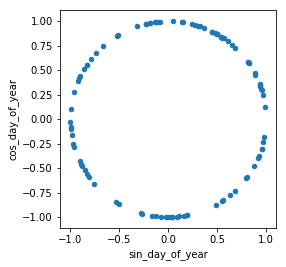

In [5]:
%matplotlib inline

df.sample(100).plot.scatter('sin_day_of_year','cos_day_of_year').set_aspect('equal')

* Split into Xtrain, Xtest, ytrain, ytest based on date
  * Training dates = 2013-01-01 to 2016-12-31
  * Test dates = 2017-01-01 to 2017-09-08
  * New data (coincides with beginning of dockless pilot) = 2017-09-09 to present

In [6]:
# Train test split
# This can be tweaked, but we use 5-fold cross-validation to pick the model so that shouldn't change

train = df.loc['2013-01-01':'2016-12-31']
test = df.loc['2017-01-01':'2017-09-08']
print(train.shape, test.shape)

tr = train.shape[0]
te = test.shape[0]
trpct = tr/(tr+te)
tepct = te/(tr+te)

print("{:0.3f} percent of the data is in the training set and {:0.3f} percent is in the test set".format(trpct, tepct))

(1461, 30) (251, 30)
0.853 percent of the data is in the training set and 0.147 percent is in the test set


In [7]:
# Specify columns to keep and drop for X and y
drop_cols = ['date', 'day_of_year']
y_cols = ['cabi_trips_wdc_to_wdc', 'cabi_trips_wdc_to_wdc_casual']

feature_cols = [col for col in df.columns if (col not in y_cols) & (col not in drop_cols)]

# X y split
Xtrain_raw = train[feature_cols]

# Our target variable here is all DC to DC trips
ytrain = train[y_cols[0]]
Xtest_raw = test[feature_cols]
ytest = test[y_cols[0]]
print(Xtrain_raw.shape, ytrain.shape, Xtest_raw.shape, ytest.shape)

(1461, 26) (1461,) (251, 26) (251,)


### 1. Preprocessing

We want to use PolynomialFeatures and StandardScaler in a Pipeline, but we only want to scale continuous features.

Here, I do the polynomial transformation first and then feed it through a pipeline because I wasn't able to get it all working in one pipeline.

* Use PolynomialFeatures to create quadratic and interaction terms
  * Convert back to DataFrame
  * Drop redundant variables
* Use Pipeline and FeatureUnion to selectively scale/ignore certain variables
* Fit and transform using pipeline to get final Xtrain and Xtest

In [8]:
# Imports and custom classes
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin

class Columns(BaseEstimator, TransformerMixin):
    """ 
    This is a custom transformer for splitting the data into subsets for FeatureUnion.
    """
    def __init__(self, names=None):
        self.names = names

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X):
        return X[self.names]
    

In [9]:
# Use PolynomialFeatures to create quadratic and interaction terms
# Should ultimately be part of a Pipeline, but I had issues because 
# PF returns an array and Columns requires a df

pf = PolynomialFeatures(2, include_bias=False)

Xtrain_pf_array = pf.fit_transform(Xtrain_raw)
Xtest_pf_array = pf.transform(Xtest_raw)

# Get feature names 
Xtrain_cols = pf.get_feature_names(Xtrain_raw.columns)

# Convert arrays to dfs with the new pf column names
Xtrain_pf = pd.DataFrame(Xtrain_pf_array, columns=Xtrain_cols)
Xtest_pf = pd.DataFrame(Xtest_pf_array, columns=Xtrain_cols)

print(Xtrain_pf.shape, Xtest_pf.shape)

(1461, 377) (251, 377)


In [10]:
# A lot of these variables are redundant, especially squared dummy variables
# All of these variables listed next are 'binary' but only some are meaningful

bin_vars = [col for col in Xtrain_pf.columns if Xtrain_pf[col].nunique() == 2]
bin_vars

['rain',
 'snow',
 'us_holiday',
 'nats_single',
 'nats_double',
 'dc_bike_event',
 'rain^2',
 'rain us_holiday',
 'rain nats_single',
 'rain nats_double',
 'rain dc_bike_event',
 'snow^2',
 'snow us_holiday',
 'us_holiday^2',
 'us_holiday nats_single',
 'us_holiday cabi_dur_full_mcn',
 'nats_single^2',
 'nats_single dc_bike_event',
 'nats_double^2',
 'dc_bike_event^2',
 'dc_bike_event cabi_dur_full_mcn']

In [11]:
# Dropping squared dummies and nonsensical interaction terms
# This part can be expanded. There's a lot of noise after PF

to_drop = [
    'rain^2', 'snow^2', 'us_holiday^2', 'nats_single^2', 'nats_double^2', 
    'dc_bike_event^2', 'sin_day_of_year^2', 'cos_day_of_year^2',
    'sin_day_of_year cos_day_of_year'
]

Xtrain_pf2 = Xtrain_pf.drop(labels=to_drop, axis=1)
Xtest_pf2 = Xtest_pf.drop(labels=to_drop, axis=1)

print(Xtrain_pf2.shape, Xtest_pf2.shape)

(1461, 368) (251, 368)


In [12]:
# Defining binary and continuous variables
# We have normal 0,1 binary variables, binary variables outside 0,1 that were created by PF, and continuous variables
# We want to ignore the 0,1s, MinMaxScale the non 0,1 binary variables, and StandardScale the continuous variables

binary = ['rain', 'snow', 'us_holiday', 'nats_single', 'nats_double', 'dc_bike_event']
binarypf = [col for col in Xtrain_pf2.columns if (Xtrain_pf2[col].nunique() == 2) & (col not in binary)]
cont = [col for col in Xtrain_pf2.columns if (col not in binary) & (col not in binarypf)]

# FeatureUnion in our pipeline shifts the ordering of the variables so we need to save the ordering here
cols = binary + binarypf + cont

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('binary', Pipeline([
            ('bincols', Columns(names=binary))
        ])),
        ('binarypf', Pipeline([
            ('binpfcols', Columns(names=binarypf)),
            ('minmax', MinMaxScaler())
        ])),
        ('continuous', Pipeline([
            ('contcols', Columns(names=cont)),
            ('scaler', StandardScaler())
        ]))
    ]))   
])

In [13]:
# Fit and transform to create our final Xtrain and Xtest

pipeline.fit(Xtrain_pf2)
Xtrain_scaled = pipeline.transform(Xtrain_pf2)
Xtest_scaled = pipeline.transform(Xtest_pf2)

# Put everything back into dfs
Xtrain = pd.DataFrame(Xtrain_scaled, columns=cols)
Xtest = pd.DataFrame(Xtest_scaled, columns=cols)
print(Xtrain.shape, Xtest.shape)

(1461, 368) (251, 368)


In [14]:
Xtrain.describe(percentiles=[.5]).round(3).transpose()

,count,mean,std,min,50%,max
rain,1461.0,0.449,0.498,0.000,0.000,1.000
snow,1461.0,0.047,0.211,0.000,0.000,1.000
us_holiday,1461.0,0.029,0.167,0.000,0.000,1.000
nats_single,1461.0,0.211,0.408,0.000,0.000,1.000
nats_double,1461.0,0.005,0.074,0.000,0.000,1.000
dc_bike_event,1461.0,0.012,0.110,0.000,0.000,1.000
rain us_holiday,1461.0,0.008,0.086,0.000,0.000,1.000
rain nats_single,1461.0,0.107,0.310,0.000,0.000,1.000
rain nats_double,1461.0,0.003,0.058,0.000,0.000,1.000
rain dc_bike_event,1461.0,0.007,0.082,0.000,0.000,1.000


In [15]:
# Appending train and test to get full dataset for cross-validation

Xfull = Xtrain.append(Xtest)
yfull = ytrain.append(ytest)
print(Xfull.shape, yfull.shape)

(1712, 368) (1712,)


### 2. Model Fitting

In [16]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import median_absolute_error as medae
from sklearn.metrics import explained_variance_score as evs
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

In [17]:
from sklearn.model_selection import KFold

def score_model(model, alpha=False):
    """ 
    Fits a model using the training set, predicts using the test set, and then calculates 
    and reports goodness of fit metrics and alpha if specified and available.
    """
    model.fit(Xtrain, ytrain)
    yhat = model.predict(Xtest)
    r2 = r2_score(ytest, yhat)
    me = mse(ytest, yhat)
    ae = mae(ytest, yhat)
    mede = medae(ytest, yhat)
    ev = evs(ytest, yhat)
    
    if alpha == True:
        print("Results from {}: \nr2={:0.3f} \nMSE={:0.3f} \
              \nMAE={:0.3f} \nMEDAE={:0.3f} \nEVS={:0.3f} \nalpha={:0.3f}".format(model, r2, me, 
                                                                                  ae, mede, ev, model.alpha_))
    else:
        print("Results from {}: \nr2={:0.3f} \nMSE={:0.3f} \
              \nMAE={:0.3f} \nMEDAE={:0.3f} \nEVS={:0.3f}".format(model, r2, me, ae, mede, ev))

def cv_score(model, cv=5):
    """
    Evaluates a model by 5-fold cross-validation and prints mean and 2*stdev of scores.
    Shuffles before cross-validation but sets random_state=7 for reproducibility.
    """
    kf = KFold(n_splits=cv, shuffle=True, random_state=7)
    scores = cross_val_score(model, Xfull, yfull, cv=kf)
    print(scores)
    print("Accuracy: {:0.3f} (+/- {:0.3f})".format(scores.mean(), scores.std() * 2))
    

In [18]:
'''Elastic Net'''
from sklearn.linear_model import ElasticNetCV

t = time.perf_counter()

# Alphas to search over
# Our alpha is usually in the low double digits
# This sets our search space to 250 steps between 10^0=1 and 10^2=100
alphas = np.logspace(0, 2, 250)

# Suggested l1_ratio from docs
l1_ratio = [.1, .5, .7, .9, .95, .99, 1]

en = ElasticNetCV(l1_ratio=l1_ratio, alphas=alphas, fit_intercept=True, normalize=False)

score_model(en, alpha=True)
print("L1 ratio=",en.l1_ratio_)

elapsed_time = (time.perf_counter() - t)/60
print("This cell took {:0.2f} minutes to run".format(elapsed_time))

C:\Users\slbau\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Results from ElasticNetCV(alphas=array([   1.     ,    1.01867, ...,   98.16753,  100.     ]),
       copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=1000,
       n_alphas=100, n_jobs=1, normalize=False, positive=False,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0): 
r2=0.695 
MSE=2900493.709               
MAE=1232.440 
MEDAE=904.068 
EVS=0.706 
alpha=17.578
L1 ratio= 1.0
This cell took 0.57 minutes to run


C:\Users\slbau\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [19]:
'''Lasso'''
from sklearn.linear_model import LassoCV

t = time.perf_counter()

lasso = LassoCV(alphas=alphas, n_alphas=250, fit_intercept=True, normalize=False)
score_model(lasso, alpha=True)

elapsed_time = (time.perf_counter() - t)/60
print("This cell took {:0.2f} minutes to run".format(elapsed_time))

C:\Users\slbau\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Results from LassoCV(alphas=array([   1.     ,    1.01867, ...,   98.16753,  100.     ]),
    copy_X=True, cv=None, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=250, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False): 
r2=0.695 
MSE=2900493.709               
MAE=1232.440 
MEDAE=904.068 
EVS=0.706 
alpha=17.578
This cell took 0.17 minutes to run


C:\Users\slbau\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [20]:
# Which variables were selected?

# Put coefficients and variable names in df
lassodf = pd.DataFrame(lasso.coef_, index=Xtrain.columns)

# Select nonzeros
results = lassodf[(lassodf.T != 0).any()]

# Sort by magnitude
results['sorted'] = results[0].abs()
results.sort_values(by='sorted', inplace=True, ascending=False)

print("Lasso chooses {} variables".format(len(results)))
print(results)

Lasso chooses 73 variables
                                                   0       sorted
cabi_dur_empty_arl                       1102.419467  1102.419467
apparenttemperaturehigh cos_day_of_year   865.538859   865.538859
visibility cos_day_of_year               -847.114806   847.114806
humidity precipprobability               -533.499043   533.499043
apparenttemperaturehigh dc_pop            486.114288   486.114288
cos_day_of_year                          -429.329733   429.329733
cabi_dur_empty_arl^2                     -421.096951   421.096951
sin_day_of_year                          -395.431284   395.431284
apparenttemperaturehigh visibility        374.557298   374.557298
cabi_dur_full_arl^2                      -266.962070   266.962070
cabi_dur_full_alx                         232.265298   232.265298
daylight_hours dc_pop                     229.218891   229.218891
cabi_dur_full_arl                         192.863458   192.863458
cloudcover precipintensitymax            -188.922

C:\Users\slbau\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\slbau\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [21]:
'''Ridge'''
from sklearn.linear_model import RidgeCV

t = time.perf_counter()

rr = RidgeCV(alphas=alphas, fit_intercept=True, normalize=False)

score_model(rr, alpha=True)

cv_score(rr)

elapsed_time = (time.perf_counter() - t)/60
print("This cell took {:0.2f} minutes to run".format(elapsed_time))

Results from RidgeCV(alphas=array([   1.     ,    1.01867, ...,   98.16753,  100.     ]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False): 
r2=0.301 
MSE=6654858.628               
MAE=1534.113 
MEDAE=1100.226 
EVS=0.301 
alpha=100.000
[ 0.77584136  0.85975288  0.81177338  0.85366058  0.86416417]
Accuracy: 0.833 (+/- 0.068)
This cell took 0.31 minutes to run


In [22]:
'''RF'''
from sklearn.ensemble import RandomForestRegressor

t = time.perf_counter()

rf = RandomForestRegressor() 
score_model(rf)

cv_score(rf)

elapsed_time = (time.perf_counter() - t)/60
print("This cell took {:0.2f} minutes to run".format(elapsed_time))

Results from RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False): 
r2=0.849 
MSE=1442133.498               
MAE=959.316 
MEDAE=808.700 
EVS=0.856
[ 0.90858945  0.90663605  0.88156439  0.90164226  0.90623181]
Accuracy: 0.901 (+/- 0.020)
This cell took 0.10 minutes to run


In [23]:
t = time.perf_counter()

# Cross-validation
cv_score(lasso, cv=5)

elapsed_time = (time.perf_counter() - t)/60
print("This cell took {:0.2f} minutes to run".format(elapsed_time))

C:\Users\slbau\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\slbau\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\slbau\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\slbau\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increa

[ 0.8523053   0.85221829  0.83782696  0.84932459  0.8706892 ]
Accuracy: 0.852 (+/- 0.021)
This cell took 1.15 minutes to run


In [24]:
end_time = (time.perf_counter() - start_time)/60
print("This notebook took {:0.2f} minutes to run".format(end_time))

This notebook took 2.39 minutes to run


To do:
* No polynomials, 3 polynomials
* How to interpret the coefficients?
* Modify train/test split size